# Parallelizing predictions with Dask

## Introduction: What is Dask ?

- Dask is a Python API allowing the *data community* to work in python data science environment **at scale**
- It offers a good alternative to other APIs (e.g. PySpark) because it is easier to relate for python users. 
- If you're used to use Numpy, Pandas or scikit-learn then you won't feel lost and will be able to scale your data science workflow without much effort. It contains:
    - Arrays
    - DataFrames
    - Bags (unstructured data)


## Introduction: What is Dask distributed ?

- Python library allowing distributed computation on moderate sized clusters
- Architecture:
    - One central node *scheduler* which coordinates the actions of one or several other *worker* nodes

- The scheduler is asynchronous and event-driven in nature. 
- Communications is done through *TCP*
- It is possible to switch from distributed to local by not mentionning the schedulers address to the client

(Explain what is Dask)
(To use later)
(Maybe we don't need this part)
## Dask and our cluster

- To use Dask distributed we need:
    - A cluster...
    - A Dask scheduler
    - Some workers : Docker containers with same python environment as the scheduler's one
- A distributed file system (e.g. Hadoop)

### Steps:

1. Launch the scheduler
2. Instantiate workers
3. Instantiate a Dask client in the main program

**N.B**: If we don't want to use the distributed env we can just create a client without specifying the scheduler.

In [1]:
from distributed.client import Client
# c = Client("localhost:8786")
c = Client()
c

Client Scheduler: tcp://127.0.0.1:41097 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 16.67 GB


- Note that a Dashboard is created which allows to follow the computations while executing

In [2]:
# from distributed.client import Client
# c = Client()
# c.restart()

In [3]:
import numpy as np
import pandas as pd
import sys
import time
sys.path.append("../python/")

In [4]:
c.get_versions(check=True)

{'scheduler': {'host': (('python', '3.6.9.final.0'),
   ('python-bits', 64),
   ('OS', 'Linux'),
   ('OS-release', '4.15.0-66-generic'),
   ('machine', 'x86_64'),
   ('processor', 'x86_64'),
   ('byteorder', 'little'),
   ('LC_ALL', 'None'),
   ('LANG', 'fr_FR.UTF-8'),
   ('LOCALE', 'fr_FR.UTF-8')),
  'packages': {'required': (('dask', '2.8.0'),
    ('distributed', '2.8.0'),
    ('msgpack', '0.6.2'),
    ('cloudpickle', '1.2.2'),
    ('tornado', '6.0.3'),
    ('toolz', '0.10.0')),
   'optional': (('numpy', '1.17.4'),
    ('pandas', '0.25.3'),
    ('bokeh', '1.4.0'),
    ('lz4', None),
    ('dask_ml', '1.1.1'),
    ('blosc', None))}},
 'workers': {'tcp://127.0.0.1:33371': {'host': (('python', '3.6.9.final.0'),
    ('python-bits', 64),
    ('OS', 'Linux'),
    ('OS-release', '4.15.0-66-generic'),
    ('machine', 'x86_64'),
    ('processor', 'x86_64'),
    ('byteorder', 'little'),
    ('LC_ALL', 'None'),
    ('LANG', 'fr_FR.UTF-8'),
    ('LOCALE', 'fr_FR.UTF-8')),
   'packages': {'require

- The client is the interface through which we interact with the scheduler

## Using the asynchronous engine

- The client is the interface through wich we can compute ou operations.
- Functions are applied in a distributed environment 
- In a distributed context, they are deployed as **futures** (asynchronously executed callables).

### submit

In [5]:
import time
def inc(x):
    time.sleep(2)
    return x + 1
test_submit = c.submit(inc, 10)
test_submit

<Future: pending, key: inc-e1f6ae3084c33dac2d9ea2da9ae59ef1>

In [6]:
test_submit.result()

11

### map

In [7]:
def square(x):
    time.sleep(2)
    return x**2
test_map = c.map(square, [i for i in range(11)])
test_map

[<Future: pending, key: square-49806a7cba62f84f4c156ca21ee69dbc>,
 <Future: pending, key: square-ca79d69aff1c8cd583e7379dae58b289>,
 <Future: pending, key: square-a21d8a0c2abe4623d4ac77ce4e5e33b7>,
 <Future: pending, key: square-34d7f1200f2eae8f9d19068eddeb0dec>,
 <Future: pending, key: square-32abfd095665172fc85b0dcd7a55c3ed>,
 <Future: pending, key: square-edfcd06a155455bea49c4e60edafea3f>,
 <Future: pending, key: square-1982e49728aa58808fe9d357aa353f6d>,
 <Future: pending, key: square-597b7d3d9c7adf4c153d992e7defcdfa>,
 <Future: pending, key: square-eb0999d544b6e1c5109d2319d444a4b1>,
 <Future: pending, key: square-1b22da30a7623a965ecfcc5cd5610dc4>,
 <Future: pending, key: square-ae323b08d1c9e00863955b947be2750f>]

In [8]:
c.gather(test_map)

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81, 100]

- Future.result() is the methode used to gather the result of a single future
- Future.gather() used in the case we want to compute several futures

## Computation graphs and lazy evaluation

- When manipulating dask objects, most operations are lazily evaluated
- Dask builds a computation graph and can keep trace of intermediate computations to avoid redundancy

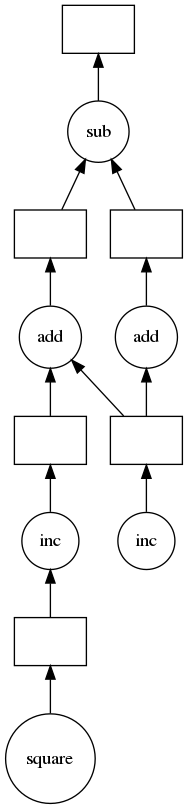

In [9]:
from dask.delayed import delayed

@delayed
def inc(x):
    return x + 1
@delayed
def square(x):
    return x**2

a = inc(1)
b = square(2)
d = inc(b)
e = a + d
f = a + 3
g = f - e
g.visualize()

In [10]:
g.compute()

-2

## Working with dask DataFrames

In [11]:
import dask.dataframe as dd
import os
# fraud = dd.read_csv('./test_data/fraud-*.csv')

In [12]:
DATA_DIR = "hdfs://bourbaki-3/user/hdfs/Data/Meetup"
fraud = dd.read_csv(DATA_DIR + '/test_data/fraud_5-*.csv').iloc[:, 1:]

- The use of wildcards is because data is partitioned in several files
- Note the proximity with pandas syntax.

In [13]:
fraud

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
npartitions=100,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In the Dask DataFrame above, Dask has:

- Read the headers
- Guessed the type of each column

In [14]:
fraud.shape

(Delayed('int-1f7b5cc9-f14b-49da-b072-5b76b87af563'), 31)

- The first element of shape is not known at this moment is returned as a delayed object
- We can make some operations on it:

In [15]:
a = fraud.shape[0] + 1

- To retrieve the result we need to call the compute method.

In [16]:
a.compute()

5696141

- Note that calling `len(a)` will trigger the `compute()` method automatically

- Most operations on Dask DataFrames are lazily evaluated
- To trigger the actual evaluation, we need the `compute()` method.

In [17]:
fraud.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
npartitions=1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [18]:
fraud.describe().compute()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,5.696140e+06,5.696140e+06,5.696140e+06,5.696140e+06,5.696140e+06,5.696140e+06,5.696140e+06,5.696140e+06,5.696140e+06,5.696140e+06,...,5.696140e+06,5.696140e+06,5.696140e+06,5.696140e+06,5.696140e+06,5.696140e+06,5.696140e+06,5.696140e+06,5.696140e+06,5.696140e+06
mean,9.481386e+04,6.383551e-16,-3.832046e-17,-2.759073e-15,2.107626e-15,1.277029e-15,1.303375e-15,-1.251802e-15,3.768778e-16,-1.762981e-15,...,8.943437e-17,7.026217e-16,2.299228e-16,4.445174e-15,9.321453e-16,1.812269e-15,-3.557117e-16,-9.900451e-17,8.834962e+01,1.727486e-03
std,4.748807e+04,1.958693e+00,1.651306e+00,1.516252e+00,1.415866e+00,1.380244e+00,1.332269e+00,1.237092e+00,1.194351e+00,1.098630e+00,...,7.345228e-01,7.257004e-01,6.244593e-01,6.056461e-01,5.212772e-01,4.822262e-01,4.036318e-01,3.300827e-01,2.501197e+02,4.152712e-02
min,0.000000e+00,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000e+00,0.000000e+00
25%,6.142600e+04,-7.663715e-01,-4.824720e-01,-3.793634e-01,-7.061485e-01,-4.093779e-01,-6.514015e-01,-4.787135e-01,-1.314902e-01,-5.337175e-01,...,-2.251419e-01,-5.239428e-01,-1.301482e-01,-3.189305e-01,-1.321533e-01,-2.821043e-01,-6.088078e-02,-1.543614e-02,6.950000e+00,0.000000e+00
50%,1.237830e+05,1.670425e-01,1.785876e-01,6.138786e-01,1.823908e-01,2.435785e-01,-1.610822e-01,1.590763e-01,8.242617e-02,4.095161e-02,...,1.579035e-02,1.480748e-01,5.160336e-02,8.357370e-02,1.691317e-01,-1.290092e-03,1.579632e-02,2.414557e-02,2.500000e+01,0.000000e+00
75%,1.658300e+05,1.985457e+00,8.916958e-01,1.376618e+00,1.014756e+00,8.613822e-01,4.829891e-01,7.334868e-01,4.014035e-01,7.183771e-01,...,2.481326e-01,7.318251e-01,2.346538e-01,5.296928e-01,4.198160e-01,3.205099e-01,1.060637e-01,8.112082e-02,8.525000e+01,0.000000e+00
max,1.727920e+05,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,2.569116e+04,1.000000e+00


In [19]:
sum_fraud = fraud.sum(axis=0)

In [20]:
sum_fraud.compute()

Time      5.400730e+11
V1        3.636160e-09
V2       -2.182787e-10
V3       -1.571607e-08
V4        1.200533e-08
V5        7.274139e-09
V6        7.424205e-09
V7       -7.130438e-09
V8        2.146749e-09
V9       -1.004219e-08
V10       1.147771e-08
V11       1.113222e-08
V12      -1.367880e-08
V13       5.329639e-09
V14       7.185008e-09
V15       2.233719e-08
V16       8.285497e-09
V17       7.639755e-10
V18       5.163201e-09
V19       4.811227e-09
V20       2.945399e-09
V21       5.094307e-10
V22       4.002231e-09
V23       1.309672e-09
V24       2.532033e-08
V25       5.309630e-09
V26       1.032294e-08
V27      -2.026184e-09
V28      -5.639436e-10
Amount    5.032518e+08
Class     9.840000e+03
dtype: float64

In [23]:
gb = fraud.groupby('Class')[['Amount', 'V1']].mean()
gb['Amount2'] = gb['Amount'] / 1000
gb

,Amount,V1,Amount2
npartitions=1,,,
,float64,float64,float64
,...,...,...


In [24]:
gb.compute()

,Amount,V1,Amount2
Class,,,
0,88.291022,0.008258,0.088291
1,122.211321,-4.771948,0.122211


**WARNING:**
- Group_by reduces the number partitions to a small number of partitions
- If the number of groups is large it can lead to memory issues
- A possible solution is to explicitly repartition on the grouping key and use `map_partitions()`

# Parallelizing the prediction of the model

- In order to parallelize predictions on a distributed dataframe, we need to have an already trained model.
- We can either import it from as a pickle, or any other format. For the sake of the demonstration we will create one directly in the notebook.

In [25]:
from sklearn.linear_model import LogisticRegression

X_cols = fraud.drop('Class', axis=1).columns

# We take a small sub-sample for training
fraud0 = fraud.sample(frac=0.1).compute() 
y = fraud0['Class'].values
X = fraud0[X_cols].values


clf = LogisticRegression(solver='warn')
clf.fit(X, y)

/home/iaamini/Documents/adobis-staytime/venv2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

- Once we have a trained model, we will distribute its evaluation on the full DataFrame
- We need: 
    1. To define a function to apply the prediction in parallel
    2. To distribute the trained model on all workers

In [26]:
def predict_model(x, model):
    return model.predict([x])[0]

- We use *c.scatter()* to distribute the model

In [27]:
future_model = c.scatter(clf, broadcast=True)

- Now we apply the predict function row wise

In [28]:
predictions = fraud[X_cols].sample(frac=0.1).apply(predict_model, model=future_model, axis=1)

ValueError: Metadata inference failed in `apply`.

You have supplied a custom function and Dask is unable to 
determine the type of output that that function returns. 

To resolve this please provide a meta= keyword.
The docstring of the Dask function you ran should have more information.

Original error is below:
------------------------
AttributeError("'Future' object has no attribute 'predict'", 'occurred at index 0')

Traceback:
---------
  File "/home/iaamini/Documents/adobis-staytime/venv2/lib/python3.6/site-packages/dask/dataframe/utils.py", line 169, in raise_on_meta_error
    yield
  File "/home/iaamini/Documents/adobis-staytime/venv2/lib/python3.6/site-packages/dask/dataframe/core.py", line 4741, in _emulate
    return func(*_extract_meta(args, True), **_extract_meta(kwargs, True))
  File "/home/iaamini/Documents/adobis-staytime/venv2/lib/python3.6/site-packages/dask/utils.py", line 881, in __call__
    return getattr(obj, self.method)(*args, **kwargs)
  File "/home/iaamini/Documents/adobis-staytime/venv2/lib/python3.6/site-packages/pandas/core/frame.py", line 6928, in apply
    return op.get_result()
  File "/home/iaamini/Documents/adobis-staytime/venv2/lib/python3.6/site-packages/pandas/core/apply.py", line 186, in get_result
    return self.apply_standard()
  File "/home/iaamini/Documents/adobis-staytime/venv2/lib/python3.6/site-packages/pandas/core/apply.py", line 292, in apply_standard
    self.apply_series_generator()
  File "/home/iaamini/Documents/adobis-staytime/venv2/lib/python3.6/site-packages/pandas/core/apply.py", line 321, in apply_series_generator
    results[i] = self.f(v)
  File "/home/iaamini/Documents/adobis-staytime/venv2/lib/python3.6/site-packages/pandas/core/apply.py", line 112, in f
    return func(x, *args, **kwds)
  File "<ipython-input-26-6b551b503038>", line 2, in predict_model
    return model.predict([x])[0]


- Dask complains that it can't guess the output type
- We need to help, so we apply our function on a small DataFrame:

In [29]:
res0 = fraud0[X_cols].sample(2).apply(predict_model, model=clf,  axis=1)

In [30]:
res0

62214    0
57826    0
dtype: int64

- We then provide the type information through the `meta` argument

In [31]:
predictions = fraud[X_cols].sample(frac=0.1).apply(predict_model, model=future_model, axis=1, meta=res0)

In [32]:
predictions.to_csv('preds/predictions_apply-*.csv', index=False)

['/home/iaamini/Documents/adobis-staytime/adobis-staytime-prediction/notebooks/preds/predictions_apply-00.csv',
 '/home/iaamini/Documents/adobis-staytime/adobis-staytime-prediction/notebooks/preds/predictions_apply-01.csv',
 '/home/iaamini/Documents/adobis-staytime/adobis-staytime-prediction/notebooks/preds/predictions_apply-02.csv',
 '/home/iaamini/Documents/adobis-staytime/adobis-staytime-prediction/notebooks/preds/predictions_apply-03.csv',
 '/home/iaamini/Documents/adobis-staytime/adobis-staytime-prediction/notebooks/preds/predictions_apply-04.csv',
 '/home/iaamini/Documents/adobis-staytime/adobis-staytime-prediction/notebooks/preds/predictions_apply-05.csv',
 '/home/iaamini/Documents/adobis-staytime/adobis-staytime-prediction/notebooks/preds/predictions_apply-06.csv',
 '/home/iaamini/Documents/adobis-staytime/adobis-staytime-prediction/notebooks/preds/predictions_apply-07.csv',
 '/home/iaamini/Documents/adobis-staytime/adobis-staytime-prediction/notebooks/preds/predictions_apply-0

- Note that we have subsampled the DataFrame because execution is actually slow
- We can significantly improve the execution time by applying the prediction function to a full partition at once

In [33]:
def predict_model(X, model):
    return pd.Series(model.predict(X), index=X.index)

In [34]:
res0 = predict_model(fraud0[X_cols], clf)

In [35]:
predictions = fraud[X_cols].map_partitions(predict_model, model=future_model, meta=res0)

In [3]:
predictions

NameError: name 'predictions' is not defined

In [37]:
predictions.to_csv('preds/predictions_apply-*.csv', index=False)

KeyboardInterrupt: 

# (Partial) Conclusion

- We've shown how to distribute the prediction step of an already existing model
- Here we've performed computations locally, but the only change needed to distribute on a cluster is to provide the address of the scheduler (and of course have workers ready on the cluster)
- The case shown above comes from a real-life use case, but not the most common one.
- Dask can be used also to:
    - Data processing
    - Learning models on big data set
    - Distribute gridsearch parameter exploration on medium/small datasets

# Use case: Parallelizing GridSearch with Dask

- In the standard version of sklearn's Gridsearch, when using Pipelines some computations are repeated several times

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression


pipe = Pipeline([("PCA", PCA()), ("logreg", LogisticRegression())])

param_grid = {"PCA__n_components": [10, 20], "logreg__C": [0.01, 0.1, 1]}

- For each of the 6 parameter sets, the initial PCA is recomputed while two computations are actually needed.

In [39]:
from sklearn.model_selection import train_test_split

X = fraud0[X_cols]
y = fraud0['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [1]:
%%time
import sklearn.model_selection as sms
clf = sms.GridSearchCV(pipe, param_grid=param_grid, cv=3, n_jobs=8)
clf.fit(X_train, y_train)

NameError: name 'pipe' is not defined

- Since Dask uses computation graphs internally it can save previous computations for later uses
- Which avoids redundant computations

In [ ]:
%%time
import dask_ml.model_selection as dms
clf = dms.GridSearchCV(pipe, param_grid=param_grid, cv=3, n_jobs=8)
clf.fit(X_train, y_train)

- Several algorithms are implemented in dask_ML. But the purpose is not to make their computation faster but it is to make them scalable. So it can deal with large datasets, but the overhead due to distribution on small distribution maybe important.